In [314]:
import numpy as np
import simulation_manager, results_annalysis
import matplotlib.pyplot as plt
import time
import pandas as pd

In [315]:
def P_aug(N,bit): 
    P = np.zeros((N,N*bit))
    b = np.array([2**i for i in range(bit)])
    for i in range(N):
        debut = i*bit
        fin = debut + bit 
        P[i,debut:fin] = b 

    return P 

In [316]:
P_aug(4,3)

array([[1., 2., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 2., 4., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 2., 4., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 4.]])

In [317]:
def reduction_markovitz(sigma,mu,alpha,K,bit=1,penaly = 0):
    """
    From the covariance matrix and the excpected return vector returns the J and H 
    of the Ising mapping 

    ARGS: 
    sigma: covariance matrix 
    mu: excpected return vector
    alpha : aversion constant 
    K : The budget 
    penalty: If we add the constraint in the energy 
    Output: 
    J : 
    H: 
    """
    Bit_max = int(np.log2(K))
    bit = Bit_max
    N = len(mu) # Number of assets considered 
    U = np.ones(bit*N) 
    P = P_aug(N,bit)
    sigma_augmented = P.T @ sigma @ P
    mu_augmented = P.T @ mu 
    I_augmented = P.T @ np.ones(N)

    J = - (alpha/2)* sigma_augmented
    H = (alpha/2) * sigma_augmented @ U - mu_augmented - penaly*I_augmented
    np.fill_diagonal(J,0)

    # J_compact = np.zeros((len(J)+1,len(J)+1))
    # J_compact[:,]


    return J,H



In [318]:
def reverse(solution,N,K): 
    solution += 1
    solution /=2
    bit = int(np.log2(K))
    P = P_aug(N,bit)
    return P@solution

# **Testing the SB**

Defining $\Sigma$ and $\mu$

In [319]:
# Covariance matrix (example values)
sigma= np.array([[1.0, 1.2, 0.7], [1.2, 1.0, -1.9], [0.7, -1.9, 1.0]])

# Expected return vector (example values)
mu = np.array([0.2, 0.05, 0.17])



In [320]:
# import numpy as np

# # Generate random covariance matrix (100x100)
# sigma = np.random.rand(4, 4)
# sigma = np.dot(sigma, sigma.T)  # Make it symmetric
# sigma = sigma / np.max(np.abs(sigma))  # Normalize to control magnitude

# # Generate random expected return vector (length 100)
# mu = np.random.rand(4)
# mu = mu / np.sum(mu)  # Normalize so that the sum equals 1


In [321]:
# import numpy as np

# # Covariance matrix (example values)
# sigma = np.array([[1.0, 0.2, 0.1], [0.2, 0.8, 0.3], [0.1, 0.3, 0.6]])

# # Expected return vector (example values)
# mu = np.array([0.12, 0.08, 0.15])


In [322]:
J,H = reduction_markovitz(sigma,mu,alpha = 2,K=10,bit=3,penaly= 1)

In [323]:
np.log2(10)

3.321928094887362

In [324]:
eigs = np.linalg.eigvals(J)
ksi = 1/(eigs.max())
p_first = 1-ksi*np.real(eigs.max())
p_last = 1-ksi*np.real(eigs.min())
num_iterations = 1000
lag = 0

def pumpuing_rate(self, t):
    # return t/100
    if t<lag:
        return 0
    else:
        return 1 * p_last * (t-lag)/(num_iterations-lag)

In [325]:
manager = simulation_manager.SimulationManager(step_size=0.5, num_iterations=num_iterations, num_simulations=2, J=J, H=H, pumping_rate=pumpuing_rate, stopping_criterion=0.1, save_states_history=True, save_energies_history=True, n_threads=2, savetofile=False)

In [326]:
states, energies, last_states, last_TAC_states, last_sign_States, last_energies, last_TAC_energies, last_sign_energies, final_times, sign_times, TAC_times = manager.run_simulation()


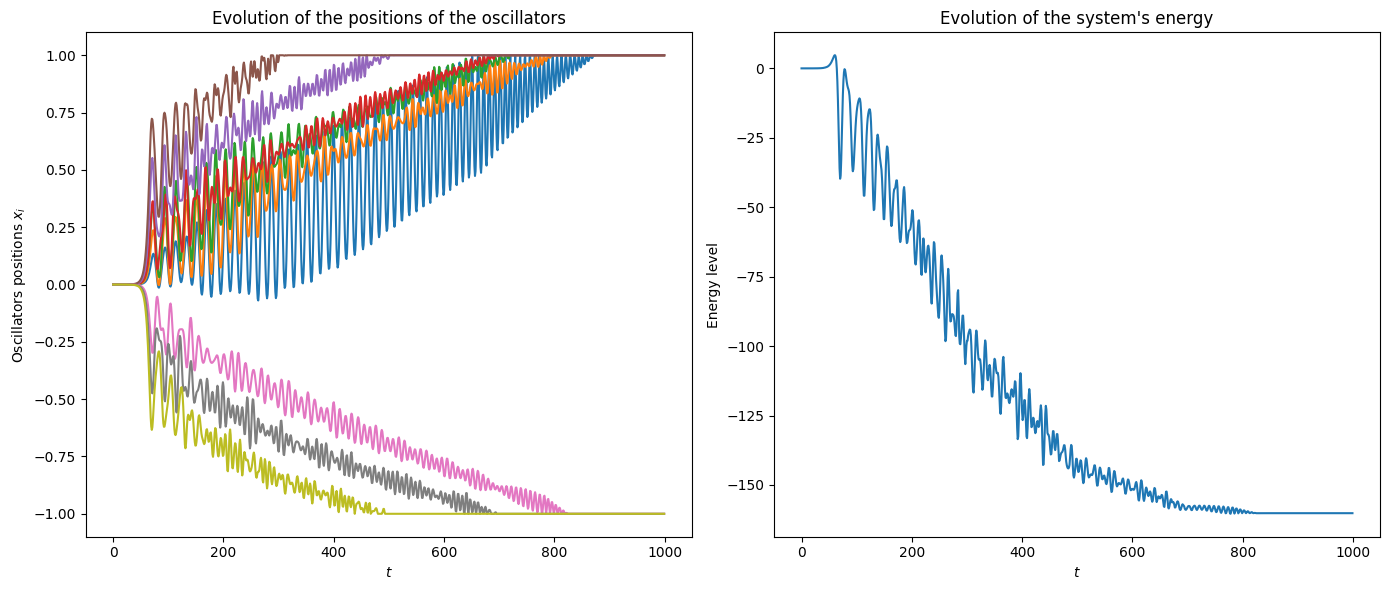

In [327]:
results_annalysis.complete_plot(states, energies, 0)


In [328]:
solution = np.sign(last_states[0, :, 0])
solution

array([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.])

# **Result analysis with random assets**

In [329]:
import numpy as np

def geometric_brownian_motion(n_assets, n_time, initial_prices, drift=0.05, volatility=0.1):
    """Generate price paths from a geometric Brownian motion."""
    dt = 1  # Time step
    prices = np.zeros((n_assets, n_time))
    prices[:, 0] = initial_prices

    for i in range(n_assets):
        for t in range(1, n_time):
            prices[i, t] = prices[i, t - 1] * np.exp((drift - 0.5 * volatility**2) * dt +
                                                      volatility * np.sqrt(dt) * np.random.normal())

    return prices

def estimate_parameters(n_assets, n_time, initial_prices, drift=0.05, volatility=0.1):
    """Estimate future return vector μ and covariance matrix S."""
    prices = geometric_brownian_motion(n_assets, n_time, initial_prices, drift, volatility)
    returns = np.diff(prices, axis=1) / prices[:, :-1]
    mu = np.mean(returns, axis=1)
    S = np.cov(returns)
    return mu, S

# Example usage
N = 5  # Number of assets
T = 1000  # Number of time increments  

initial_prices = [100, 50, 10, 1, 20]

# Here we explicitly set the drift term to the average expected return
mu, S = estimate_parameters(N, T, initial_prices=initial_prices, volatility=0.1)
print("Future return vector μ:\n", mu)
print("Covariance matrix S:\n", S)


Future return vector μ:
 [0.0491284  0.05325718 0.0541276  0.04624836 0.05187205]
Covariance matrix S:
 [[ 1.07423492e-02  1.91107500e-04 -7.37615116e-05 -1.46956291e-04
   1.19039530e-04]
 [ 1.91107500e-04  1.04517503e-02 -5.00714842e-04  2.36861967e-04
   1.05149277e-04]
 [-7.37615116e-05 -5.00714842e-04  1.16283835e-02  1.06362519e-04
   2.65360085e-04]
 [-1.46956291e-04  2.36861967e-04  1.06362519e-04  1.13397802e-02
  -2.54471527e-04]
 [ 1.19039530e-04  1.05149277e-04  2.65360085e-04 -2.54471527e-04
   1.18517297e-02]]


In [330]:
J,H = reduction_markovitz(S,mu,K=15,alpha=1,penaly=1) 

In [331]:
eigs = np.linalg.eigvals(J)
ksi = 1/(eigs.max())
p_first = 1-ksi*np.real(eigs.max())
p_last = 1-ksi*np.real(eigs.min())
num_iterations = 1000
lag = 0

def pumpuing_rate(self, t):
    # return t/100
    if t<lag:
        return 0
    else:
        return 1 * p_last * (t-lag)/(num_iterations-lag)

In [332]:
manager = simulation_manager.SimulationManager(step_size=0.5, num_iterations=num_iterations, num_simulations=2, J=J, H=H, pumping_rate=pumpuing_rate, stopping_criterion=0.1, save_states_history=True, save_energies_history=True, n_threads=2, savetofile=False)
states, energies, last_states, last_TAC_states, last_sign_States, last_energies, last_TAC_energies, last_sign_energies, final_times, sign_times, TAC_times = manager.run_simulation()

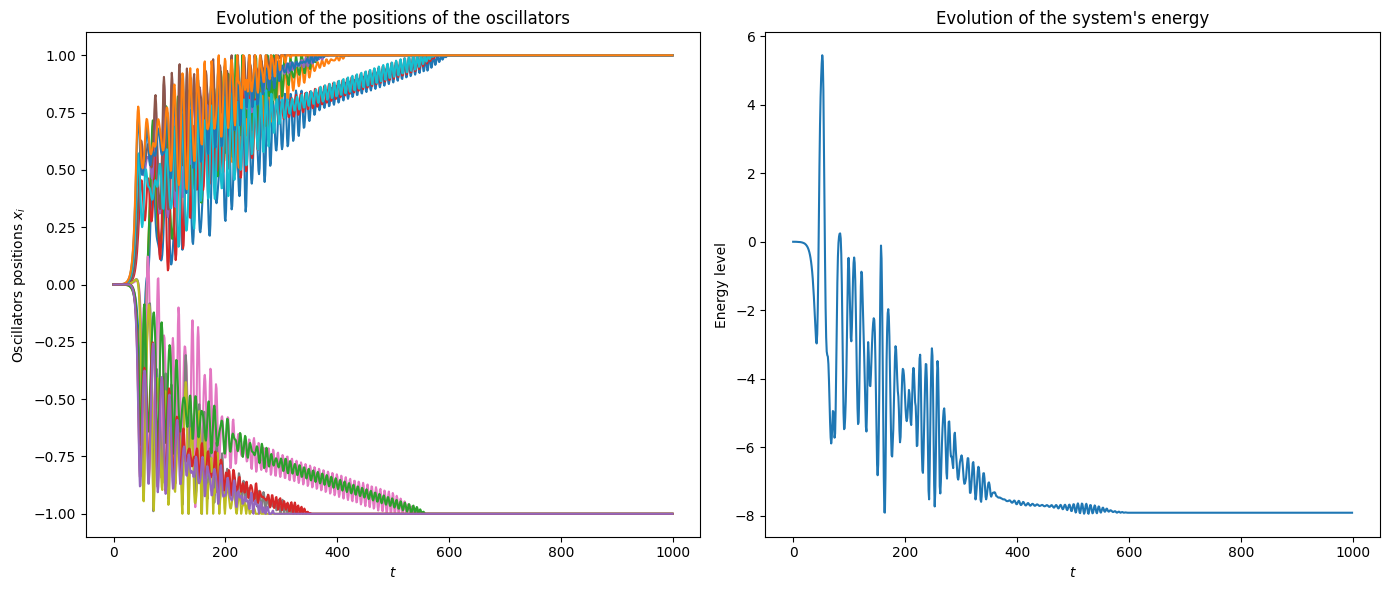

In [333]:
results_annalysis.complete_plot(states, energies, 0)

In [334]:
solution = np.sign(last_states[0, :, 0])
solution

array([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1., -1.,
       -1., -1.])

In [335]:
w_opt = reverse(solution,N,K=15)
w_opt  = w_opt/sum(w_opt)
w_opt

array([0.33333333, 0.33333333, 0.        , 0.33333333, 0.        ])

Show the universe of possible portfolios 

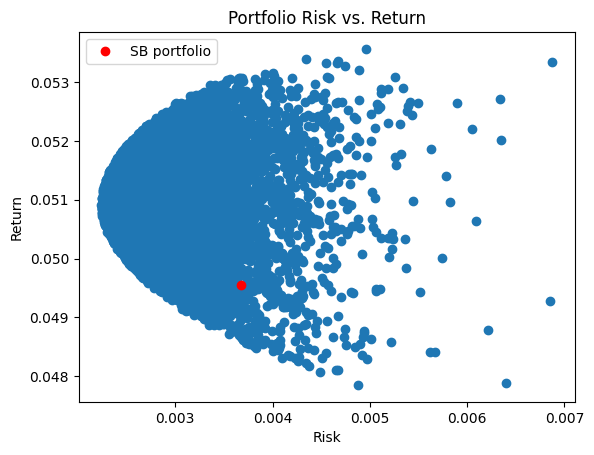

In [336]:
risque = []
retour = []

for _ in range(10000): 
    w = np.random.uniform(0, 15, N)
    w /= sum(w)
    wsw = w.T @ S @ w
    wmu = w.T @ mu

    risque.append(wsw)
    retour.append(wmu)

plt.scatter(risque, retour)
risque_SB = w_opt.T @ S @ w_opt 
return_SB = w_opt.T @ mu 
plt.plot(risque_SB, return_SB, 'ro', label='SB portfolio')  # Plot the SB portfolio point
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Portfolio Risk vs. Return')
plt.legend()
plt.show()
